In [1]:
from bubblewrap import Bubblewrap
import numpy as np
from ava.models.vae import VAE,X_SHAPE
from ava.models.window_vae_dataset import get_window_partition, get_fixed_window_data_loaders
from ava.preprocessing.utils import get_spec
from ava.preprocessing.preprocess import tune_window_preprocessing_params,get_audio_filenames
import os
import glob
from scipy.io import wavfile

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/miles/.local/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/miles/.local/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


## Load data for VAE

In [2]:
dataPath = '/home/miles/isilon/All_Staff/birds/goldberg'
bird = 'Bird2CU22001'
conditions = ['*PBS*','*Drug*']
fullPath = os.path.join(dataPath,bird)
fullPaths = sum([glob.glob(os.path.join(fullPath,c)) for c in conditions],[])

wavs = [glob.glob(os.path.join(p,'*.wav')) for p in fullPaths]
times = [glob.glob(os.path.join(p,'*.time.txt')) for p in fullPaths]
for w,t in zip(wavs,times):
    w.sort()
    t.sort()

fs,_ = wavfile.read(wavs[0][0])

In [3]:
print(fullPaths)

['/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240611_Drug_t2']


In [45]:
p = {
	'fs': fs,
	'get_spec': get_spec,
	'num_freq_bins': X_SHAPE[0],
	'num_time_bins': X_SHAPE[1],
	'nperseg': 512, # FFT
	'noverlap': 256, # FFT
	'max_dur': 0.1, # Big number
	'window_length': 0.01, #ms
	'min_freq': 400,
	'max_freq': 10e3,
	'spec_min_val': 1.3,
	'spec_max_val': 5.,
	'mel': True, # Frequency spacing
	'time_stretch': False,
	'within_syll_normalize': False,
	'real_preprocess_params': ('min_freq', 'max_freq', 'spec_min_val', \
			'spec_max_val'),
	'int_preprocess_params': tuple([]),
	'binary_preprocess_params': ('mel', 'within_syll_normalize'),
}

p = tune_window_preprocessing_params(fullPaths, p)
#afs = get_audio_filenames(fullPaths[0])
#afs = np.array(afs)
#file_index = np.random.randint(len(afs))
#audio_filename = afs[file_index]
#fs, audio = wavfile.read(audio_filename)
#duration = len(audio) / fs
#print(audio.shape)

Tune preprocessing parameters:


Set value for min_freq: [400]  
Set value for max_freq: [10000.0]  
Set value for spec_min_val: [1.3]  
Set value for spec_max_val: [5.0]  
Set value for mel: [T]  
Set value for within_syll_normalize: [F]  
Continue? [y] or [s]top tuning or [r]etune params:  s


In [11]:
def convert_txt_labels(roi_files,fs):

    new_files=[]

    for file in roi_files:
        try:
            on,off = np.loadtxt(file,delimiter=',',unpack=True)
            on,off = np.round(on/fs,4),np.round(off/fs,4)
            combined = np.stack([on,off]).T
            header = "Onsets/offsets for " + file
            seg_fn = file.split('.txt')[0] + 'combined.txt'
            np.savetxt(seg_fn, combined, fmt='%.5f', header=header)

            new_files.append(seg_fn)
        except:
            print(file)
            raise NotImplementedError
    return new_files

In [14]:
print(new_files)

['/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg1_20240610112205.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg2_20240610112825.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg3_20240610112842.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg4_20240610113037.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00009_seg5_20240610113833.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00009_seg6_20240610114143.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00013_seg7_20240610115049.timecombined.txt'

In [16]:
print(times[0])

['/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg1_20240610112205.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg2_20240610112825.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg3_20240610112842.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg4_20240610113037.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00009_seg5_20240610113833.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00009_seg6_20240610114143.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00013_seg7_20240610115049.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22

In [17]:
new_files = [convert_txt_labels(t,fs) for t in times]

In [46]:
partition = get_window_partition(fullPaths, fullPaths, 1,roi_suffix='.timecombined.txt')
partition['test'] = partition['train']
num_workers = min(7, os.cpu_count()-1)
loaders = get_fixed_window_data_loaders(partition, p, \
	num_workers=num_workers, batch_size=128,save_memory=False,min_spec_val=0.2)
loaders['test'] = loaders['train']

In [51]:
model = VAE(save_dir=f'/home/miles/Downloads/goldberg_budgie_data/{bird}_single_session_VAE_exclude_silence_10ms')

In [52]:
model.train_loop(loaders, epochs=2001, test_freq=100,save_freq=250,vis_freq=100)

Training: epochs 0 to 2000
Training set: 2048
Test set: 2048
Epoch: 0 Average loss: 71826.8420
Test loss: 5312.9543
Epoch: 1 Average loss: 13726.0319
Epoch: 2 Average loss: 5744.6222
Epoch: 3 Average loss: 3460.0363
Epoch: 4 Average loss: 2479.9313
Epoch: 5 Average loss: 1995.6588
Epoch: 6 Average loss: 1866.8355
Epoch: 7 Average loss: 1855.5010
Epoch: 8 Average loss: 1695.0824
Epoch: 9 Average loss: 1680.2181
Epoch: 10 Average loss: 1694.5015
Epoch: 11 Average loss: 1489.0866
Epoch: 12 Average loss: 1622.2892
Epoch: 13 Average loss: 1454.3900
Epoch: 14 Average loss: 1481.4460
Epoch: 15 Average loss: 1375.7889
Epoch: 16 Average loss: 1415.2583
Epoch: 17 Average loss: 1251.0370
Epoch: 18 Average loss: 1261.8071
Epoch: 19 Average loss: 1138.4147
Epoch: 20 Average loss: 1175.5450
Epoch: 21 Average loss: 1044.5788
Epoch: 22 Average loss: 1001.4562
Epoch: 23 Average loss: 934.2645
Epoch: 24 Average loss: 880.8836
Epoch: 25 Average loss: 825.0150
Epoch: 26 Average loss: 790.7039
Epoch: 27 Av

In [7]:
model.load_state(os.path.join(f'/home/miles/Downloads/goldberg_budgie_data/{bird}_single_session_VAE_excludesilence','checkpoint_2000.tar'))

## To-do: 
- [x] embed vocalization as trajectories
- [ ] fit bubblewrap
- [ ] estimate fisher
- [x] estimate fisher on toy data

## Analysis

### embed full vocalizations

In [134]:
import torch
from tqdm import tqdm
p['embed_overlap'] = 0.5
shoulder=0.05
#def embed_voc(wav,roi,model):
    
def embed_vocalizations(model,parameters,partition):

    wavs,rois = partition['audio'],partition['rois']
    wavLats = []
    for w,r in tqdm(zip(wavs,rois),desc='embedding segments'):
        
        sr,aud = wavfile.read(w)
        aud = aud[:,0]
        ons,offs = np.loadtxt(r,unpack=True)
        print(len(ons))
        #print(ons)
        print(r)
        print(w)
        #assert False
        for ii,(on,off) in enumerate(zip(ons,offs)):
            roiSpecs = []
            os = np.arange(on,off,(1 - parameters['embed_overlap'])*parameters['window_length'])
            fs = os + parameters['window_length']
            for o,f in zip(os,fs):
                target_times = np.linspace(o, f, \
    						parameters['num_time_bins'])
                #print(target_times.shape)
                #print(o.shape,f.shape)
                spec, flag = parameters['get_spec'](max(0.0, o-shoulder), \
						f+shoulder, aud, parameters, \
						fs=sr, target_times=target_times)
                if np.amax(spec) >= 0.01:
                    roiSpecs.append(spec)
                
            if len(roiSpecs) > 0:
                roiSpecs = np.stack(roiSpecs)
    
                lats,_,_ = model.encode(torch.from_numpy(roiSpecs).type(torch.FloatTensor).to(model.device))
                wavLats.append(lats.detach().cpu().numpy())
        
            else:
                print(f"removing {w} segment {ii}")

    print(len(wavLats))

    print("removed {} out of {} vocalizations")
    
    return wavLats

            
            


#### embed drug data

In [141]:
drug = ['*Drug_t1']
#fullPath = os.path.join(dataPath,bird)
drugPaths = sum([glob.glob(os.path.join(fullPath,c)) for c in drug],[])

wavs_drug = [glob.glob(os.path.join(p,'*.wav')) for p in drugPaths]

times_drug = [glob.glob(os.path.join(p,'*.timecombined.txt')) for p in drugPaths]
for w,t in zip(wavs_drug,times_drug):
    w.sort()
    t.sort()

In [142]:
os.listdir(fullPath)

['20240527_Drug_t1', '20240611_Drug_t2', '20240610_PBS_t2', '20240526_PBS_t1']

In [143]:
drug_lats = [np.vstack(embed_vocalizations(model,p,{'audio':wav,'rois':time})) for wav,time in zip(wavs_drug,times_drug)]

embedding segments: 1it [00:00,  3.12it/s]

3
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00019_seg1_20240527121004.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00019_seg1_20240527121004.wav
3
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00024_seg2_20240527122507.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00024_seg2_20240527122507.wav


embedding segments: 3it [00:00,  3.32it/s]

3
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00027_seg3_20240527122840.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00027_seg3_20240527122840.wav


embedding segments: 4it [00:01,  2.95it/s]

5
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00028_seg4_20240527122951.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00028_seg4_20240527122951.wav
1027
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00028_seg5_20240527123145.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1/Pair3CU22001CU54_warble_00028_seg5_20240527123145.wav


embedding segments: 5it [00:28,  5.75s/it]

1041
removed {} out of {} vocalizations


In [144]:
print(len(drug_lats))
for d in drug_lats:
    print(d.shape)

1
(31857, 32)


#### embed normal data

In [145]:
pbs = ['*PBS_t1']
#fullPath = os.path.join(dataPath,bird)
pbsPaths = sum([glob.glob(os.path.join(fullPath,c)) for c in pbs],[])

wavs_pbs = [glob.glob(os.path.join(p,'*.wav')) for p in pbsPaths]
times_pbs = [glob.glob(os.path.join(p,'*.timecombined.txt')) for p in pbsPaths]
for w,t in zip(wavs_pbs,times_pbs):
    w.sort()
    t.sort()

In [146]:
pb_lats = [np.vstack(embed_vocalizations(model,p,{'audio':wav,'rois':time})) for wav,time in zip(wavs_pbs,times_pbs)]

embedding segments: 0it [00:00, ?it/s]

1147
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00005_seg1_20240526112118.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00005_seg1_20240526112118.wav


embedding segments: 1it [00:34, 34.80s/it]

388
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00006_seg2_20240526114511.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00006_seg2_20240526114511.wav


embedding segments: 2it [00:46, 21.24s/it]

315
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00007_seg3_20240526115026.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00007_seg3_20240526115026.wav


embedding segments: 3it [00:55, 15.63s/it]

165
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00008_seg4_20240526115320.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00008_seg4_20240526115320.wav


embedding segments: 4it [01:00, 11.47s/it]

19
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00008_seg5_20240526115436.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00008_seg5_20240526115436.wav


embedding segments: 5it [01:01,  7.72s/it]

481
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00009_seg6_20240526115453.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00009_seg6_20240526115453.wav


embedding segments: 6it [01:15,  9.73s/it]

541
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00010_seg7_20240526115823.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00010_seg7_20240526115823.wav


embedding segments: 7it [01:33, 12.45s/it]

507
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00011_seg8_20240526120231.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00011_seg8_20240526120231.wav


embedding segments: 8it [01:50, 13.97s/it]

192
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00012_seg9_20240526120600.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00012_seg9_20240526120600.wav


embedding segments: 10it [01:56,  7.96s/it]

2
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00013_seg10_20240526120741.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00013_seg10_20240526120741.wav
26
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg11_20240526123638.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg11_20240526123638.wav


embedding segments: 11it [01:57,  5.86s/it]

13
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg12_20240526123700.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg12_20240526123700.wav


embedding segments: 12it [01:58,  4.31s/it]

5
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg13_20240526123714.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg13_20240526123714.wav


embedding segments: 13it [01:58,  3.14s/it]

31
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg14_20240526123722.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg14_20240526123722.wav


embedding segments: 14it [01:59,  2.50s/it]

31
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg15_20240526123734.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg15_20240526123734.wav


embedding segments: 15it [02:00,  2.06s/it]

47
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg16_20240526123753.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg16_20240526123753.wav


embedding segments: 16it [02:02,  1.93s/it]

16
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg17_20240526123812.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg17_20240526123812.wav


embedding segments: 17it [02:03,  1.51s/it]

34
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg18_20240526123820.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg18_20240526123820.wav


embedding segments: 18it [02:04,  1.42s/it]

98
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg19_20240526123842.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00019_seg19_20240526123842.wav


embedding segments: 19it [02:06,  1.77s/it]

167
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00020_seg20_20240526124003.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00020_seg20_20240526124003.wav


embedding segments: 20it [02:11,  2.75s/it]

159
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00020_seg21_20240526124108.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00020_seg21_20240526124108.wav


embedding segments: 21it [02:16,  3.44s/it]

188
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00020_seg22_20240526124435.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00020_seg22_20240526124435.wav


embedding segments: 22it [02:21,  3.88s/it]

113
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg23_20240526125035.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg23_20240526125035.wav


embedding segments: 23it [02:25,  3.72s/it]

38
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg24_20240526125159.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg24_20240526125159.wav


embedding segments: 24it [02:26,  2.93s/it]

136
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg25_20240526125216.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg25_20240526125216.wav
removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg25_20240526125216.wav segment 101


embedding segments: 25it [02:35,  4.72s/it]

124
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg26_20240526125301.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg26_20240526125301.wav


embedding segments: 26it [02:38,  4.26s/it]

154
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg27_20240526125357.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg27_20240526125357.wav


embedding segments: 27it [02:42,  4.22s/it]

222
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00024_seg28_20240526125846.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00024_seg28_20240526125846.wav


embedding segments: 28it [02:48,  4.78s/it]

40
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00024_seg29_20240526130002.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00024_seg29_20240526130002.wav


embedding segments: 29it [02:49,  3.70s/it]

280
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00028_seg30_20240526131036.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00028_seg30_20240526131036.wav


embedding segments: 30it [02:56,  4.60s/it]

14
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00028_seg31_20240526131419.timecombined.txt
/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00028_seg31_20240526131419.wav


embedding segments: 31it [02:57,  5.72s/it]

5692
removed {} out of {} vocalizations


In [147]:
print(len(pb_lats))
for d in pb_lats:
    print(d.shape)

1
(182459, 32)


In [154]:
import time
start = time.time()
bw = bubblewrap_data(pb_lats[0])
print(np.round(time.time()-start,3))

387.675


In [149]:
bound_pbs = bw.get_fisher_ub()
bw_drug = bubblewrap_data(drug_lats[0])
bound_drug = bw_drug.get_fisher_ub()

In [236]:
print(bound_pbs)
print(bound_drug)

58806.363
78748.77


In [94]:
# is this really all the files? double triple check
print(len(partition['train']['audio']))

68


In [54]:
print(len(lats))

5693


## visualize

In [163]:
from jax import jit, vmap
from jax import numpy as jnp
def single_B(x,mu,L,L_diag):
    n = mu.shape[0]
    B = jnp.exp(-(jnp.linalg.norm((x-mu)@L)**2) /2)/(2*jnp.pi)**(n/2) * jnp.exp(jnp.sum(L_diag))
    return B

B_jax = jit(vmap(single_B,in_axes=(None,0,0,0)))

In [285]:
from bubblewrap import single_logB
print(bw.alpha.shape,bw.A.shape,bw.B.shape)
test_prob = B_jax(drug_lats[0][0], bw.mu,bw.L,bw.L_diag)*bw.alpha

# update to take fisher of each distribution???
precs_pbs = bw._get_precision()#.transpose(2,1,0)[None,...]
precs_drug = bw_drug._get_precision()#.transpose(2,1,0)[None,...]

drug_probs_pbs = np.vstack([B_jax(dg,bw.mu,bw.L,bw.L_diag)*bw.alpha for dg in drug_lats[0]]) # these might just need to be alphas? need to update this part and all below. and also fit to each dataset independently!!
pbs_probs_pbs = np.vstack([B_jax(p,bw.mu,bw.L,bw.L_diag)*bw.alpha for p in pb_lats[0]])
drug_probs_drug = np.vstack([B_jax(dg,bw_drug.mu,bw_drug.L,bw_drug.L_diag)*bw_drug.alpha for dg in drug_lats[0]])
pbs_probs_drug = np.vstack([B_jax(p,bw_drug.mu,bw_drug.L,bw_drug.L_diag)*bw_drug.alpha for p in pb_lats[0]])

(1000,) (1000, 1000) (1000,)


In [287]:
all_pbs = np.vstack([drug_probs_pbs,pbs_probs_pbs]).T
all_drug = np.vstack([drug_probs_drug,pbs_probs_drug]).T
precs_pbs = bw._get_precision()#.transpose(2,1,0)[None,...]
precs_drug = bw_drug._get_precision()#.transpose(2,1,0)[None,...]
print(all_drug.shape)
print(all_pbs.shape)
print(precs_pbs.shape)
print(precs_drug.shape)

precs_pbs = precs_pbs.transpose(1,2,0) @ all_pbs
precs_drug = precs_drug.transpose(1,2,0)@all_drug
print(precs_pbs.shape)
print(precs_drug.shape)
fishers_pbs,fishers_drug = np.trace(precs_pbs),np.trace(precs_drug)

(1000, 214316)
(1000, 214316)
(1000, 32, 32)
(1000, 32, 32)
(32, 32, 214316)
(32, 32, 214316)


In [185]:
colors = np.log(fishers_pbs/fishers_drug)
valid_inds = np.argwhere(1- np.isnan(colors))

print(len(valid_inds)/len(colors))

0.9590791168181564


/tmp/ipykernel_9555/2920642178.py:1: RuntimeWarning: invalid value encountered in divide
  colors = np.log(fishers_pbs/fishers_drug)


In [151]:
import umap #import UMAP

all_lats = np.vstack([drug_lats[0],pb_lats[0]])
print(all_lats.shape)
um = umap.UMAP(n_components=2,n_neighbors=15)
uml = um.fit_transform(all_lats)

(214316, 32)


In [275]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(np.vstack([drug_lats[0],pb_lats[0]]))

PCA()

In [279]:
pbs_projs,drug_projs = pca.transform(pb_lats[0]),pca.transform(drug_lats[0])
all_projs = np.vstack([drug_projs,pbs_projs])

(214316,)


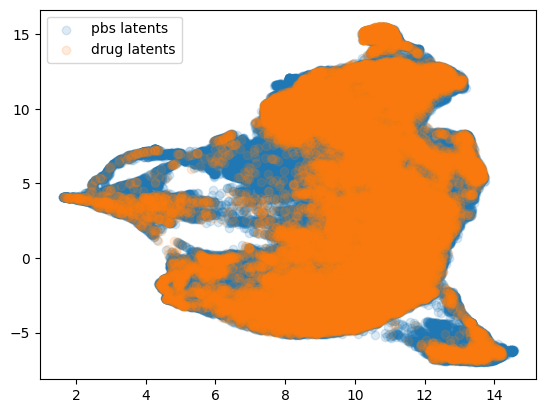

"\ncm = sns.color_palette('crest_r',as_cmap=True)\nax = plt.gca()\n\ng = ax.scatter(uml[valid_inds,0],uml[valid_inds,1],c=colors[valid_inds],cmap=cm)#label='pbs latents',alpha=0.2)\nplt.colorbar(g,ax=ax)\n#ax.scatter(uml[inds==1,0],uml[inds==1,1],color='tab:orange',label='drug latents',alpha=0.2)\nplt.show()\nplt.close()\n"

In [291]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
inds = np.hstack([np.ones((drug_lats[0].shape[0],)),2*np.ones((pb_lats[0].shape[0],))])
print(inds.shape)
ax = plt.gca()

ax.scatter(uml[inds==2,0],uml[inds==2,1],color='tab:blue',label='pbs latents',alpha=0.15)

ax.scatter(uml[inds==1,0],uml[inds==1,1],color='tab:orange',label='drug latents',alpha=0.15)
plt.legend()
plt.show()
plt.close()

"""
cm = sns.color_palette('crest_r',as_cmap=True)
ax = plt.gca()

g = ax.scatter(uml[valid_inds,0],uml[valid_inds,1],c=colors[valid_inds],cmap=cm)#label='pbs latents',alpha=0.2)
plt.colorbar(g,ax=ax)
#ax.scatter(uml[inds==1,0],uml[inds==1,1],color='tab:orange',label='drug latents',alpha=0.2)
plt.show()
plt.close()
"""

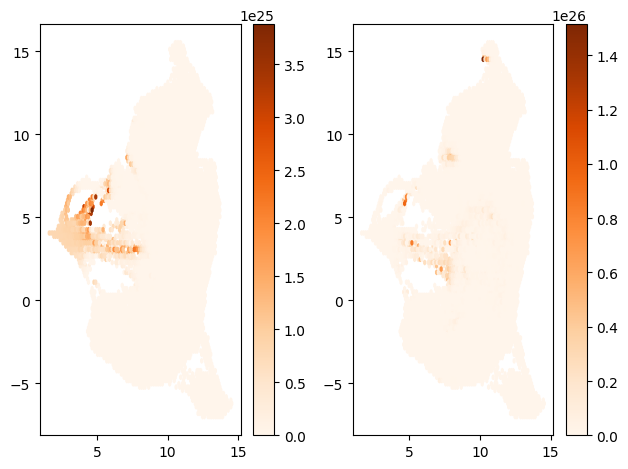

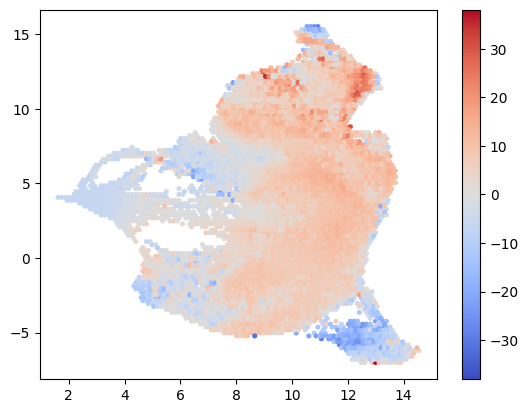

In [290]:
from matplotlib.colors import Normalize
fig = plt.figure()
ax = fig.add_subplot(121)
ax2= fig.add_subplot(122)
hb_pbs = ax.hexbin(uml[:,0].squeeze(),uml[:,1].squeeze(),C=fishers_pbs,cmap='Oranges',reduce_C_function=np.mean,gridsize=100)
hb_drug = ax2.hexbin(uml[:,0].squeeze(),uml[:,1].squeeze(),C=fishers_drug,cmap='Oranges',reduce_C_function=np.mean,gridsize=100)
pbs_local_means = hb_pbs.get_array()
drug_local_means = hb_drug.get_array()
ratios = np.log(drug_local_means/pbs_local_means)
offsets = hb_pbs.get_offsets()

cb = fig.colorbar(hb_pbs,ax=ax)
cb2 = fig.colorbar(hb_drug,ax=ax2)
plt.tight_layout()
plt.show()
plt.close()

max_val = np.amax(np.abs(ratios))
norm = Normalize(vmin=-max_val,vmax=max_val)
fig = plt.figure()
ax = plt.gca()

hb_ratios = ax.hexbin(offsets[:,0],offsets[:,1],C=ratios,cmap='coolwarm',norm=norm)
cb = fig.colorbar(hb_ratios,ax=ax)
plt.show()
plt.close()
#ax.scatter(uml[inds==1,0],uml[inds==1,1],color='tab:orange',label='drug latents',alpha=0.15)

### Fit bubblewrap

In [75]:

def bubblewrap_data(data):
    
    N = 1000             # number of nodes to tile with
    lam = 1e-3          # lambda 
    nu = 1e-3           # nu
    eps = 1e-3          # epsilon sets data forgetting
    step = 8e-2         # for adam gradients
    
    B_thresh = -10      # threshold for when to teleport (log scale)    
    batch = True       # run in batch mode 
    
    go_fast = True     # flag to skip computing priors, predictions, and entropy for optimal speed
    future_distance = 1

    T = data.shape[0]      
    d = data.shape[1]       # should be 32

    M = T//100              # small set of data seen for initialization
    batch_size = T//100      # batch mode size; if not batch is 1
    
    bw = Bubblewrap(N, d, step=step, lam=lam, M=M, eps=eps, nu=nu, B_thresh=B_thresh, batch=batch, batch_size=batch_size, go_fast=go_fast, future_distance=future_distance)

    #print('initializing bubblewrap...')
    step = batch_size
    for i in np.arange(0, M, step): 
        bw.observe(data[i:i+step])
    bw.init_nodes()
    #print(f"{np.sum(np.isnan(bw.L))} nan values in L")
    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for i in np.arange(init, end, step): #,desc='fitting bubblewrap....'):
        future_index = i+M+step - 2 + bw.future_distance
        future_x = data[future_index] if future_index < ((end- 1) + M ) else None
    
        bw.observe(data[i+M:i+M+step], future_x=future_x)
        bw.e_step()  
        bw.grad_Q()
        nNan = np.sum(np.isnan(bw.L))
        if nNan > 0:
            print(f"after iter {i+1}, {nNan} nans in L")

    return bw

def update_bubblewrap(bw,data):

    T = data.shape[0]      
    d = data.shape[1]
    M = T//100              # small set of data seen for initialization
    batch_size = T//100      # batch mode size; if not batch is 1

    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for i in np.arange(init, end, step): #,desc='fitting bubblewrap....'):
        future_index = i+M+step - 2 + bw.future_distance
        future_x = data[future_index] if future_index < ((end- 1) + M ) else None
    
        bw.observe(data[i+M:i+M+step], future_x=future_x)
        bw.e_step()  
        bw.grad_Q(mode='update')
        nNan = np.sum(np.isnan(bw.L))
        if nNan > 0:
            print(f"after iter {i+1}, {nNan} nans in L")

    return bw
    

    

In [ ]:
bw = bubblewrap_data(lats)
bubble_bound = bw.get_fisher_ub()